BlazePose is a novel convolutional neural network architecture for human pose estimation that can run in real-time on mobile devices. It can detect 33 body keypoints, including face, hands, and feet, which are useful for applications like fitness, dance, and gesture control. BlazePose is based on a two-step detector-tracker pipeline that first locates the pose region-of-interest and then predicts the keypoints from it. BlazePose outperforms existing pose models in terms of accuracy, speed, and memory. BlazePose can also provide clinically viable body keypoints for virtual motion assessment.


[
https://arxiv.org/abs/2006.10204
](https://)



#Installations and dependensies

In [1]:
#@title Mediapipe instalation
!pip install mediapipe

Defaulting to user installation because normal site-packages is not writeable


## Download tools from github:

In [2]:
user = "ItayCoifman"
repo = "blazepose-mediapipe-example"
src_dir = "tools"
pyfile = "video.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "visualize.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "utils.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};

--2025-12-07 14:32:18--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/video.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 7213 (7,0K) [text/plain]
Enregistre : ‘video.py’

video.py            100%[===================>]   7,04K  --.-KB/s    ds 0s      

2025-12-07 14:32:19 (37,7 MB/s) - ‘video.py’ enregistré [7213/7213]

--2025-12-07 14:32:19--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/visualize.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443… connecté.
requête HTTP transmise, en attente de la réponse

## Imports

In [3]:
# from tools import video,utils,visualize
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from video import Video
import visualize
from utils import landmarks_2_table
import mediapipe as mp
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output, display
import nbimporter
from extract_videos_by_label import get_DESRes_videos_by_label, get_jester_videos_by_label



2025-12-07 14:32:22.072197: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 14:32:22.072913: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 14:32:22.075349: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 14:32:22.082067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765085542.093414    4734 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765085542.09

## Functions

In [5]:
def video_pose_estimation_2D(video_path: str,
                          output_path: str = None,
                          save_video: bool = False,
                          verbose: bool = True):
    """
    Applique BlazePose à une vidéo.

    Args:
        video_path: chemin de la vidéo d'entrée.
        output_path: chemin de la vidéo de sortie (si save_video=True).
        save_video: si True, écrit une vidéo annotée.
        verbose: affichage des infos.

    Returns:
        vid_out (Video ou None),
        marker_df,
        visibility_df
    """
    output = []
    timestamps = []

    vid = Video.from_path(video_path)
    video_name = os.path.basename(video_path)

    # Reader
    vid_cap = cv2.VideoCapture(vid.path)

    # Writer optionnel
    video_writer = None
    if save_video:
        if output_path is None:
            base, ext = os.path.splitext(video_path)
            output_path = base + "_pose.mp4"
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        video_writer = cv2.VideoWriter(output_path, fourcc, vid.fps, (vid.width, vid.height))

    if verbose:
        print(f"Processing- Name- {video_name}:")
        print(f" Width- {vid.width}, Height- {vid.height} ")
        print(f" number of frames- {vid.nFrames}, Fps- {vid.fps} ")
        print(f" Path-{video_path} \n")

    # BlazePose
    with mp.solutions.pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:

        for frame_index in tqdm(range(vid.nFrames)):
            success, img = vid_cap.read()
            if not success:
                break

            # BGR -> RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # timestamp
            timestamps.append(vid_cap.get(cv2.CAP_PROP_POS_MSEC))

            # Inference
            results = pose.process(img_rgb)
            output.append(results)

            # Dessin + écriture vidéo seulement si demandé
            if save_video and video_writer is not None:
                img_out = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
                mp.solutions.drawing_utils.draw_landmarks(
                    img_out,
                    results.pose_landmarks,
                    mp.solutions.pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp.solutions.drawing_styles.get_default_pose_landmarks_style()
                )
                video_writer.write(img_out)

    # Fermer ressources
    if video_writer is not None:
        video_writer.release()
    cv2.destroyAllWindows()

    # Landmarks -> tables
    try:
        marker_df, visibility_df = landmarks_2_table(
            output,
            time_vec=np.array(timestamps) / 1000.0
        )
    except Exception as e:
        print("⚠️ landmarks_2_table a échoué:", repr(e))
        marker_df, visibility_df = output, []
        print("please replace the video")

    vid_out = Video.from_path(output_path) if (save_video and output_path is not None) else None
    return vid_out, marker_df, visibility_df


# BlazePose Mediapipe - Extract Pose Estimation From Video:

## Upload your video

Labels disponibles : ['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand']

In [7]:
#use case
videos = get_DESRes_videos_by_label("point", 10)
videos


['GESRes_filtered_gestures/point/1666_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/942_Politician3_point_forward.mp4',
 'GESRes_filtered_gestures/point/1171_Clinician1_point_forward.mp4',
 'GESRes_filtered_gestures/point/864_Politician3_point_up.mp4',
 'GESRes_filtered_gestures/point/859_Politician3_point_moving.mp4',
 'GESRes_filtered_gestures/point/838_Politician3_point_up.mp4',
 'GESRes_filtered_gestures/point/834_Politician3_point_to_side.mp4',
 'GESRes_filtered_gestures/point/1673_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/2174_Lecturer3_point_to_side.mp4',
 'GESRes_filtered_gestures/point/863_Politician3_point_forward.mp4']

Labels disponibles : ['Drumming Fingers','Pushing Two Fingers Away','Sliding Two Fingers Down','Stop Sign','Swiping Up','Turning Hand Counterclockwise','Zooming Out With Two Fingers',
				'Pulling Hand In' ,'Rolling Hand Backward','Sliding Two Fingers Left'  , 'Swiping Down',  'Thumb Down' ,'Zooming In With Full Hand',
				'Pulling Two Fingers In','Rolling Hand Forward','Sliding Two Fingers Right','Swiping Left',  'Thumb Up' , 'Zooming In With Two Fingers',
				'Pushing Hand Away','Shaking Hand','Sliding Two Fingers Up', 'Swiping Right','Turning Hand Clockwise' ,'Zooming Out With Full Hand']


In [8]:
videos = get_jester_videos_by_label("Stop Sign", 5)
videos

['Jester_filtered_gestures/Stop Sign/34959.mp4',
 'Jester_filtered_gestures/Stop Sign/50587.mp4',
 'Jester_filtered_gestures/Stop Sign/7882.mp4',
 'Jester_filtered_gestures/Stop Sign/47616.mp4',
 'Jester_filtered_gestures/Stop Sign/143162.mp4']

## Veiw your results
Notice- Convert function is only used for presenting Video in google Colab

# Normalization

In [36]:
from scipy.signal import savgol_filter

def smooth_sequence(data, window=9, poly=3):
    """
    data : (T, D)
    Lisse chaque colonne indépendamment.
    """
    return savgol_filter(data, window_length=window, polyorder=poly, axis=0)


In [58]:
KEYPOINTS = [0, 2, 5] + list(range(7, 25)) # keypoints à utiliser
VIS_THRESH = 0.5  # seuil de visibilité (à ajuster si besoin)


def marker_to_traj_vec(marker_df,
                       visibility_df,
                       keypoints=KEYPOINTS,
                       target_len: int = 50,
                       vis_thresh: float = VIS_THRESH) -> np.ndarray:
    """
    Transforme marker_df (T_raw, 100) + visibility_df en une trajectoire
    normalisée et vectorisée pour DMP.

    Accepte indifféremment:
      - marker_df : np.ndarray ou pandas.DataFrame
      - visibility_df : np.ndarray ou pandas.DataFrame

    Retourne:
        traj_vec : (T, 2 * len(keypoints))  -> typiquement (50, 32)
        (coords = (y,z) normalisés par les épaules, resamplés en target_len)
    """

    # ---- 0) Conversion éventuelle DataFrame -> ndarray ----
    if isinstance(marker_df, pd.DataFrame):
        marker_df = marker_df.to_numpy()
    if isinstance(visibility_df, pd.DataFrame):
        visibility_df = visibility_df.to_numpy()

    T_raw = marker_df.shape[0]
    n_kp = len(keypoints)

    # -------- 1) Récupérer le temps --------
    t_src = marker_df[:, 0]  # (T_raw,)

    # -------- 2) Extraire (y, z) pour les keypoints choisis --------
    # marker_df: [time, x0,y0,z0, x1,y1,z1, ...]
    seq_yz = np.zeros((T_raw, n_kp, 2), dtype=float)  # (T_raw, 16, 2)

    for i, kp in enumerate(keypoints):
        base = 1 + 3 * kp  # x = base, y = base+1, z = base+2
        y_col = base + 1
        z_col = base + 2
        seq_yz[:, i, 0] = marker_df[:, y_col]
        seq_yz[:, i, 1] = marker_df[:, z_col]

    # -------- 3) Appliquer le masque de visibilité --------
    # visibility_df: [time, vis_0, vis_1, ..., vis_32]
    vis_sel = np.zeros((T_raw, n_kp), dtype=float)
    for i, kp in enumerate(keypoints):
        vis_col = 1 + kp
        vis_sel[:, i] = visibility_df[:, vis_col]

    # Mettre les points peu visibles à NaN
    mask_invis = (vis_sel < vis_thresh) | ~np.isfinite(vis_sel)
    seq_yz[mask_invis, :] = np.nan

    # -------- 4) Remplir les NaN par interpolation temporelle --------
    # On interpole chaque dimension (joint, coord) indépendamment
    seq_flat = seq_yz.reshape(T_raw, -1)  # (T_raw, n_kp*2)
    
    # Apply a Savitzky-Golay filter to an array.
    seq_flat = smooth_sequence(seq_flat, window=9, poly=3)

    for d in range(seq_flat.shape[1]):
        vals = seq_flat[:, d]
        finite = np.isfinite(vals)
        if finite.sum() >= 2:
            # interpolation sur les indices de temps (ou t_src si tu préfères)
            seq_flat[:, d] = np.interp(
                np.arange(T_raw),
                np.arange(T_raw)[finite],
                vals[finite]
            )
        else:
            # si quasi rien de valide : on met à 0
            seq_flat[:, d] = 0.0

    seq_yz_filled = seq_flat.reshape(T_raw, n_kp, 2)  # (T_raw, 16, 2)

    # -------- 5) Normalisation par les épaules (centrage + scale) --------
    # On suppose que 11 et 12 sont dans keypoints
    try:
        idx_sh_l = keypoints.index(11)
        idx_sh_r = keypoints.index(12)
    except ValueError:
        raise ValueError("Les keypoints 11 et 12 (épaules) doivent être dans KEYPOINTS.")

    shoulder_L = seq_yz_filled[:, idx_sh_l, :]  # (T_raw, 2)
    shoulder_R = seq_yz_filled[:, idx_sh_r, :]  # (T_raw, 2)

    centers = 0.5 * (shoulder_L + shoulder_R)  # (T_raw, 2)
    seq_centered = seq_yz_filled - centers[:, None, :]  # (T_raw, 16, 2)

    # Distance épaule-épaule pour chaque frame
    shoulder_dist = np.linalg.norm(shoulder_R - shoulder_L, axis=1)  # (T_raw,)
    finite_sd = shoulder_dist[np.isfinite(shoulder_dist) & (shoulder_dist > 1e-6)]
    if finite_sd.size == 0:
        scale = 1.0
    else:
        scale = np.mean(finite_sd)

    seq_norm = seq_centered / scale  # (T_raw, 16, 2)

    # -------- 6) Normalisation temporelle à target_len frames --------
    if target_len is not None and target_len > 0:
        # On interpole dans le temps réel t_src
        t_new = np.linspace(t_src[0], t_src[-1], target_len)
        seq_norm_flat = seq_norm.reshape(T_raw, -1)  # (T_raw, 32)
        seq_resampled_flat = np.zeros((target_len, seq_norm_flat.shape[1]), dtype=float)

        for d in range(seq_norm_flat.shape[1]):
            seq_resampled_flat[:, d] = np.interp(
                t_new, t_src, seq_norm_flat[:, d]
            )

        seq_resampled = seq_resampled_flat.reshape(target_len, n_kp, 2)  # (target_len, 16, 2)
        T_out = target_len
    else:
        seq_resampled = seq_norm
        T_out = T_raw

    # -------- 7) Vectorisation finale pour DMP : (T_out, 2 * n_kp) --------
    traj_vec = seq_resampled.reshape(T_out, n_kp * 2)  # (T_out, 32)

    return traj_vec


# DMP


In [57]:
class DMPVector:
    def __init__(self, n_basis: int = 20):
        self.n_basis = n_basis #number of gaussians
        self.centers = None
        self.widths = None
        self.W = None       # (n_basis, D)
        self.y0 = None      # (D,)
        self.g = None       # (D,)
        self.T_train = None

    #define each psi function
    def _basis_functions(self, T: int):
        t = np.linspace(0.0, 1.0, T)
        self.centers = np.linspace(0.0, 1.0, self.n_basis)
        self.widths = np.ones(self.n_basis) * (self.n_basis ** 2)
        psi = np.exp(-self.widths * (t[:, None] - self.centers[None, :])**2)
        return psi, t

    def fit(self, Y: np.ndarray):
        T, D = Y.shape
        self.T_train = T
        self.y0 = Y[0].copy()
        self.g  = Y[-1].copy()     #goal point for each trajectory

        psi, t = self._basis_functions(T)   # psi: (T, n_basis)

        # Composante linéaire entre y0 et g pour chaque dimension
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))   # (T, D)

        # Composante non linéaire à approximer
        F_target = Y - Y_lin                                # (T, D)

        # Normalisation des bases
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                           # (T, n_basis)

        # Résolution des poids W dans F_target ≈ psi_norm @ W
        # psi_norm: (T, n_basis), F_target: (T, D) -> W: (n_basis, D)
        self.W, _, _, _ = np.linalg.lstsq(psi_norm, F_target, rcond=None)

    def fit_multi(self, Y_batch: np.ndarray):
        """
        Y_batch : (N, T, D) — ensemble de N démos pour un même geste
        Apprend un seul W en empilant toutes les F_target.
        """
        N, T, D = Y_batch.shape
        self.T_train = T

        # base functions communes
        psi, t = self._basis_functions(T)           # (T, n_basis)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                    # (T, n_basis)

        # On va empiler toutes les F_target
        F_list = []

        # Pour la partie linéaire de référence, on choisit les moyennes des y0, g
        y0_all = []
        g_all  = []

        for i in range(N):
            Y = Y_batch[i]              # (T, D)
            y0_i = Y[0].copy()
            g_i  = Y[-1].copy()

            y0_all.append(y0_i)
            g_all.append(g_i)

            Y_lin_i = y0_i + np.outer(t, (g_i - y0_i))   # (T, D)
            F_i     = Y - Y_lin_i                        # (T, D)
            F_list.append(F_i)

        # Empilement
        F_all = np.concatenate(F_list, axis=0)           # (N*T, D)
        Psi_big = np.tile(psi_norm, (N, 1))              # (N*T, n_basis)

        # Régression globale
        self.W, _, _, _ = np.linalg.lstsq(Psi_big, F_all, rcond=None)

        # y0, g moyens pour ce geste
        self.y0 = np.mean(np.stack(y0_all, axis=0), axis=0)  # (D,)
        self.g  = np.mean(np.stack(g_all, axis=0),  axis=0)  # (D,)


    def rollout(self, T: int = None, amplitude_scale: float = 1.0) -> np.ndarray:
        """
        Génère une nouvelle trajectoire :
        - T : nombre de pas (si None -> même T que l'entraînement)
        - amplitude_scale : scaling global de la partie non-linéaire
        Retour : (T, D)
        """
        if T is None:
            T = self.T_train

        psi, t = self._basis_functions(T)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum

        # F: (T, D)
        F = psi_norm @ self.W * amplitude_scale

        # partie linéaire entre y0 et g
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))

        Y = Y_lin + F
        return Y


# Dataset usage



In [14]:
#Given a label and a number of video, extract marker_df and visibility_df 
#Then, normalize and resample them to build a dataset for DMP training
#output : X (N, T, 32) and video_paths (list of N strings): array of shape (N, T, 32) where N is number of videos

labels_DESRes = ['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand']
labels_jester_full = ['Drumming Fingers','Pushing Two Fingers Away','Sliding Two Fingers Down','Stop Sign','Swiping Up','Turning Hand Counterclockwise','Zooming Out With Two Fingers',
				'Pulling Hand In' ,'Rolling Hand Backward','Sliding Two Fingers Left'  , 'Swiping Down',  'Thumb Down' ,'Zooming In With Full Hand',
				'Pulling Two Fingers In','Rolling Hand Forward','Sliding Two Fingers Right','Swiping Left',  'Thumb Up' , 'Zooming In With Two Fingers',
				'Pushing Hand Away','Shaking Hand','Sliding Two Fingers Up', 'Swiping Right','Turning Hand Clockwise' ,'Zooming Out With Full Hand']

labels_jester = ['Stop Sign', 'Drumming Fingers', 'Thumb Up', 'Thumb Down', 'Turning Hand Counterclockwise', 'Turning Hand Clockwise', 
                 'Rolling Hand Backward', 'Rolling Hand Forward', 'Pushing Hand Away', 'Shaking Hand']

def build_gesture_dataset(label, n, target_len=50):
    
    if label in labels_DESRes:
        video_paths = get_DESRes_videos_by_label(label, n)
    elif label in labels_jester:
        video_paths = get_jester_videos_by_label(label, n)
    else:
        raise ValueError(f"❌ Label '{label}' non reconnu.")
    
    X = []

    for vp in video_paths:
        try:
            # On ne sauvegarde pas de vidéo ici -> save_video=False
            vid_out, marker_df, visibility_df = video_pose_estimation_2D(
                vp, save_video=False, verbose=False
            )

            traj = marker_to_traj_vec(marker_df, visibility_df, target_len=target_len)
            X.append(traj)   # (T, 32)

        except Exception as e:
            print(f"⚠️ Skip {vp} : {repr(e)}")

    if len(X) == 0:
        raise RuntimeError(
            f"❌ Aucune trajectoire n'a pu être extraite pour le label '{label}'."
        )

    X = np.stack(X, axis=0)  # (N, T, 32)
    return X, video_paths


In [ ]:
X_point, vids_point = build_gesture_dataset("point", 10, target_len=50)
X_point.shape


# Execution example :
Renvoie Y obtenu avec les 10 démo du label "point"

In [16]:
dmp_point = DMPVector(n_basis=20)
dmp_point.fit_multi(X_point)          # on utilise T et D depuis X_point

Y_gen = dmp_point.rollout(T=50)       # (50, 32)
print(Y_gen.shape)


(50, 42)


# Generalization 
Let's create the dictionnary for each label

In [ ]:
gesture_dmps = {}

labels = labels_DESRes + labels_jester

for lab in labels:
    X_lab, vids_lab = build_gesture_dataset(lab, n=100, target_len=50)
    dmp = DMPVector(n_basis=20)
    dmp.fit_multi(X_lab)
    gesture_dmps[lab] = dmp


# Sauvegarder résultat obtenu 

In [18]:
!pip install joblib


Defaulting to user installation because normal site-packages is not writeable


In [19]:
import joblib

# Sauvegarde dans un fichier binaire
joblib.dump(gesture_dmps, "gesture_dmps_2D.joblib")

print("✔️ DMPs saved !")

✔️ DMPs saved !


# Results analysis 

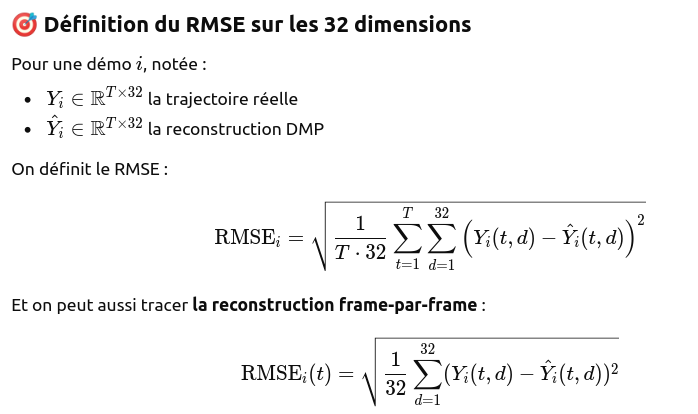

In [43]:
#Function evaluation DMP reconstruction

def evaluate_dmp_reconstruction(dmp, X_batch):
    """
    X_batch : (N, T, D)
    Retourne :
    - rmse_all : (N,) RMSE globale par démo
    - rmse_per_frame : (N, T) RMSE par frame
    """
    N, T, D = X_batch.shape

    # Reconstructions
    Y_hat = np.zeros_like(X_batch)

    for i in range(N):
        Y_hat[i] = dmp.rollout(T=T)  # Reconstruction DMP

    err = X_batch - Y_hat  # (N, T, D)

    rmse_per_frame = np.sqrt(np.mean(err**2, axis=2))  # (N, T)
    rmse_all = np.sqrt(np.mean(err**2, axis=(1,2)))    # (N,)
    rmse_mean = rmse_all.mean()

    return rmse_all, rmse_per_frame, rmse_mean

In [ ]:
def analyse_label(label, n=100, target_len=50, n_basis=30):
    """
    Construit le dataset pour `label`, entraîne un DMP multi-démos,
    calcule les RMSE et trace RMSE par frame (toutes les vidéos + moyenne).

    Retourne :
      - rmse_all        : (N,) RMSE globale par démo
      - rmse_per_frame  : (N, T) RMSE à chaque frame
      - dmp             : le DMPVector entraîné
      - X               : (N, T, D) les trajectoires utilisées
      - vids            : liste des chemins de vidéos
    """

    # 1) Dataset
    X, vids = build_gesture_dataset(label, n=n, target_len=target_len)

    # 2) Train DMP multi-démos
    dmp = DMPVector(n_basis=n_basis)
    dmp.fit_multi(X)

    # 3) Evaluate reconstruction
    rmse_all, rmse_per_frame, rmse_mean = evaluate_dmp_reconstruction(dmp, X)

    # 4) Stats globales
    # print(f"\n=== Résultats pour le label: {label} ===")
    # print("RMSE par démo :", rmse_all)
    # print("RMSE moyenne :", rmse_all.mean())
    # print("RMSE max :", rmse_all.max())
    # print("Number of videos ", rmse_all.shape[0])
    # 5) Plot RMSE per frame
    plt.figure(figsize=(10, 5))
    for i in range(rmse_per_frame.shape[0]):
        plt.plot(rmse_per_frame[i], alpha=0.25)

    # Courbe moyenne
    plt.plot(rmse_per_frame.mean(axis=0), color='red', linewidth=3, label='Moyenne')

    plt.title(f"RMSE per frame for '{label}'")
    plt.xlabel("Frame")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    return rmse_all, rmse_per_frame, rmse_mean, dmp, X, vids

In [60]:
def analyse_label_filtered(label, 
                           n=100, 
                           target_len=50, 
                           n_basis=30, 
                           rmse_threshold=0.4):

    # 1) Dataset
    X_raw, vids_raw = build_gesture_dataset(label, n=n, target_len=target_len)
    N_raw = len(X_raw)

    print(f"\n🔎 {label} : {N_raw} videos loaded")

    # 2) DMP multi-démos
    dmp_full = DMPVector(n_basis=n_basis)
    dmp_full.fit_multi(X_raw)

    # 3) RMSE multi-démos
    rmse_all, rmse_per_frame, rmse_mean = evaluate_dmp_reconstruction(dmp_full, X_raw)

    print(f"📊 Mean RMSE (filtered)  : {rmse_mean:.4f}")
    print(f"📈 RMSE max : {rmse_all.max():.4f}")

    # 4) Filtrage basé sur RMSE multi-démos
    keep_mask = rmse_all < rmse_threshold
    print(f"🧹 Filtrage : {keep_mask.sum()}/{len(keep_mask)} vidéos gardées (< {rmse_threshold})")

    X = X_raw[keep_mask]
    vids = [vids_raw[i] for i in range(N_raw) if keep_mask[i]]   # ⭐ CORRECTIF ICI ⭐

    if len(X) == 0:
        print("⚠️ Aucune vidéo n'a passé le filtrage pour ce label. Analyse ignorée.")
        return None, None, None, None, []


    # 5) Réentraîner le DMP multi-démos
    dmp = DMPVector(n_basis=n_basis)
    dmp.fit_multi(X)

    # 6) RMSE final
    rmse_all_f, rmse_per_frame_f, rmse_mean_f = evaluate_dmp_reconstruction(dmp, X)

    print("\n📊 Mean RMSE (filtered) :", rmse_mean_f)
    print("📈 RMSE max :", rmse_all_f.max())
    print("📉 RMSE min :", rmse_all_f.min())

    # Plot
    plt.figure(figsize=(10, 5))
    for i in range(rmse_per_frame_f.shape[0]):
        plt.plot(rmse_per_frame_f[i], alpha=0.25)

    plt.plot(rmse_per_frame_f.mean(axis=0), color='red', linewidth=3, label='Moyenne')

    plt.title(f"RMSE per frame for '{label}' (filtered)")
    plt.xlabel("Frame")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    return rmse_all_f, rmse_per_frame_f, dmp, X, vids, rmse_all


Utiliser fonction analyse_label("label") pour visualiser les résultats obtenus pour un label.

In [ ]:
analyse_label("Stop Sign", n=50, target_len=50, n_basis=30)

In [ ]:
rmse_all, rmse_per_frame, dmp, Xf, vids_f, rmse_raw = analyse_label_filtered(
    "Stop Sign",
    n=100,
    target_len=50,
    n_basis=40,
    rmse_threshold=0.35
)

# Analyse de tous les labels du dataset DESRes en même temps

In [ ]:
def analyse_full_DESRes(): 
    for i in labels_DESRes:
        print(analyse_label_filtered(i, n=100, target_len=50, n_basis=30)) 
    
analyse_full_DESRes()

### Analyse label from Jester Dataset

I0000 00:00:1765093889.645529    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765093889.647232  241655 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765093889.764713  241642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765093889.796925  241647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 37.10it/s]
I0000 00:00:1765093890.674278    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765093890.675249  241706 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/144898.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765093903.517198  242403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765093903.542819  242413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.78it/s]
I0000 00:00:1765093904.418556    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765093904.419591  242475 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765093904.461003  242463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765093904.486744  242466 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/76066.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765093915.308822    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765093915.310420  243089 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765093915.355964  243074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765093915.384648  243084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.27it/s]
I0000 00:00:1765093916.215492    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765093916.216864  243140 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/45523.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765093929.206005  243855 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765093929.255668  243841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765093929.278874  243849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.92it/s]
I0000 00:00:1765093930.115439    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765093930.116441  243906 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765093930.174322  243893 inference_feedback_manager.cc:114] Feedba


🔎 Stop Sign : 47 videos loaded
📊 Mean RMSE (filtered)  : 0.3879
📈 RMSE max : 1.2275
🧹 Filtrage : 33/47 vidéos gardées (< 0.4)

📊 Mean RMSE (filtered) : 0.1773069019063456
📈 RMSE max : 0.4414124806969698
📉 RMSE min : 0.060020222929303965


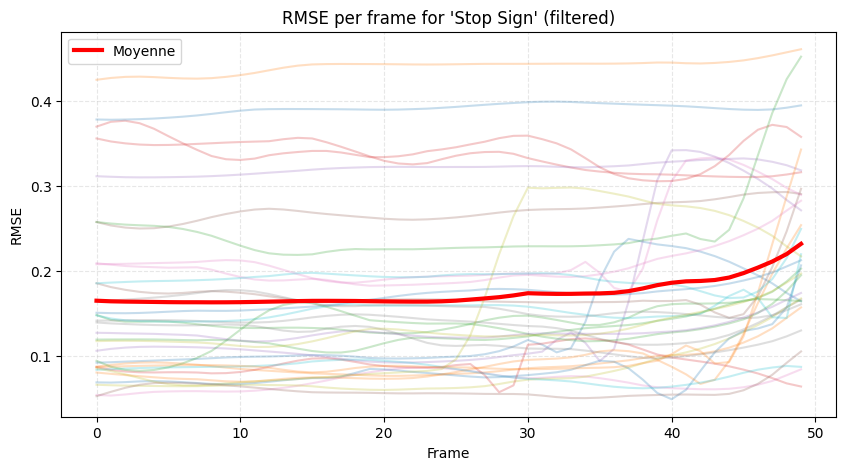

(array([0.14301704, 0.09307212, 0.1447352 , 0.3337424 , 0.17773434,
       0.1730005 , 0.06926688, 0.1369432 , 0.08407932, 0.15342474,
       0.0877769 , 0.10013796, 0.12878989, 0.09106105, 0.32104436,
       0.27041469, 0.22893857, 0.12053449, 0.19100642, 0.08162351,
       0.17026979, 0.11381154, 0.13208108, 0.34292349, 0.12886916,
       0.06002022, 0.20548636, 0.1583791 , 0.13210025, 0.19158737,
       0.39114262, 0.44141248, 0.25270073]), array([[0.09157506, 0.09208549, 0.09279552, ..., 0.18513498, 0.17380233,
        0.16397747],
       [0.08698733, 0.08892148, 0.09058578, ..., 0.13206678, 0.1444949 ,
        0.15678416],
       [0.14785336, 0.14202022, 0.13992925, ..., 0.17523523, 0.18744644,
        0.20250692],
       ...,
       [0.37861566, 0.37828321, 0.37854299, ..., 0.39049459, 0.39251465,
        0.39523979],
       [0.42545623, 0.42762614, 0.42888915, ..., 0.45425292, 0.45788445,
        0.46154038],
       [0.25755691, 0.25579912, 0.25451663, ..., 0.38634559, 0.4261815

I0000 00:00:1765093935.861520    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765093935.862388  244213 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765093935.918347  244195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765093935.944610  244200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.60it/s]
I0000 00:00:1765093936.805395    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765093936.807050  244264 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/78770.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765093946.197738  244758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765093946.224788  244762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.97it/s]
I0000 00:00:1765093947.061645    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765093947.063063  244826 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765093947.119311  244810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765093947.146251  244817 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/56069.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765093980.663177  246653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765093980.691368  246659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.99it/s]
I0000 00:00:1765093981.498889    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765093981.500345  246717 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765093981.584513  246703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765093981.618221  246708 inference_feedback_ma


🔎 Drumming Fingers : 48 videos loaded
📊 Mean RMSE (filtered)  : 0.4791
📈 RMSE max : 0.9676
🧹 Filtrage : 25/48 vidéos gardées (< 0.4)

📊 Mean RMSE (filtered) : 0.18451625834563898
📈 RMSE max : 0.4517963382853517
📉 RMSE min : 0.0758854215727354


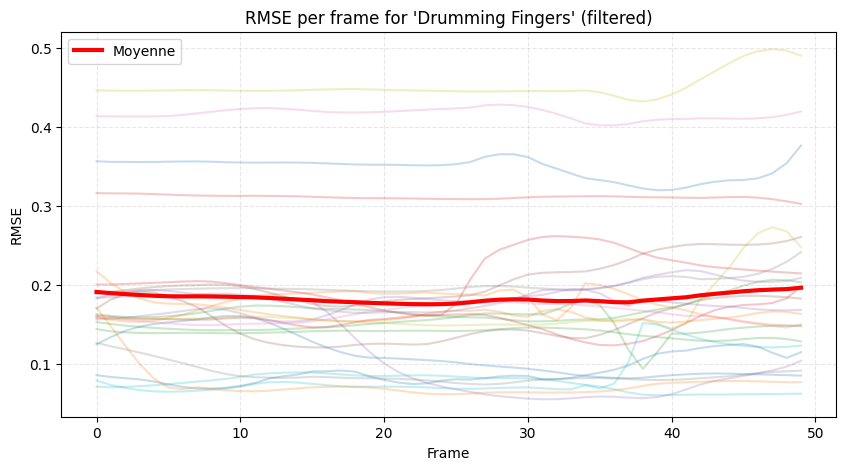

I0000 00:00:1765093982.683444    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.34825455, 0.17615783, 0.1693898 , 0.21329105, 0.12605759,
       0.15375595, 0.41655619, 0.19947589, 0.45179634, 0.07588542,
       0.11414577, 0.16530524, 0.14924977, 0.15493379, 0.17314754,
       0.21010385, 0.16202395, 0.08724231, 0.17045569, 0.08951225,
       0.09110255, 0.07692112, 0.13881613, 0.3111198 , 0.18820608]), array([[0.35650191, 0.35573118, 0.35564266, ..., 0.34122823, 0.3541311 ,
        0.37656928],
       [0.15908419, 0.15523153, 0.15333387, ..., 0.14931479, 0.14796901,
        0.14728906],
       [0.16251763, 0.16048222, 0.15912744, ..., 0.20621406, 0.20579516,
        0.20304994],
       ...,
       [0.14373066, 0.14086326, 0.13954523, ..., 0.13258906, 0.13114583,
        0.12827367],
       [0.31607723, 0.31584495, 0.31569801, ..., 0.3084149 , 0.30568104,
        0.30248039],
       [0.18360687, 0.18408486, 0.18505948, ..., 0.20355018, 0.20480128,
        0.20869149]]), <__main__.DMPVector object at 0x7caa48ae8430>, array([[[ 0.37968223,  0.03147227,  0

I0000 00:00:1765093982.684405  246768 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765093982.750825  246750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765093982.776406  246756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.14it/s]
I0000 00:00:1765093983.557077    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765093983.558542  246820 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765093983.602624  246807 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/90297.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094014.136133  248495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094014.159150  248504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.16it/s]
I0000 00:00:1765094015.010526    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094015.011612  248563 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094015.056857  248546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094015.086533  248554 inference_feedback_ma


🔎 Thumb Up : 49 videos loaded
📊 Mean RMSE (filtered)  : 0.5347
📈 RMSE max : 1.2262
🧹 Filtrage : 15/49 vidéos gardées (< 0.4)

📊 Mean RMSE (filtered) : 0.2203745439110868
📈 RMSE max : 0.5914890195479076
📉 RMSE min : 0.11000985124924373


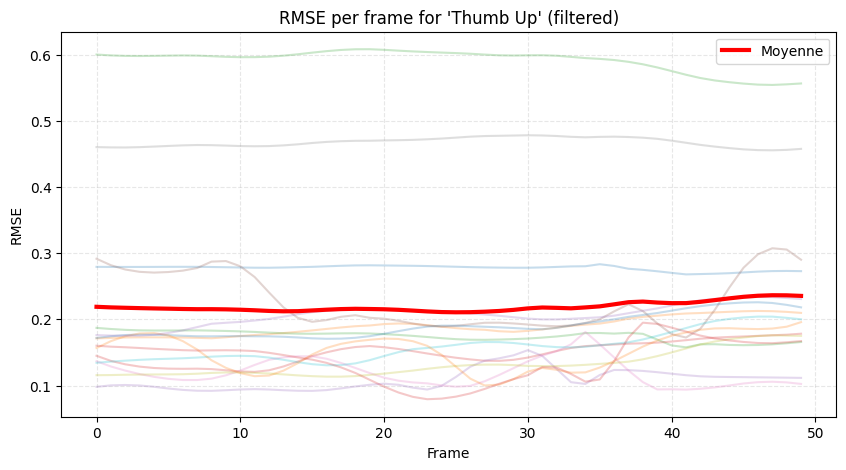

(array([0.27756462, 0.18996222, 0.17481712, 0.15003089, 0.11000985,
       0.23215969, 0.12162575, 0.4674997 , 0.13378442, 0.16077268,
       0.19134023, 0.15433633, 0.59148902, 0.1425517 , 0.20767394]), array([[0.27934992, 0.27920754, 0.27921046, 0.2792069 , 0.27927491,
        0.27938262, 0.27941217, 0.27936845, 0.27913215, 0.27877211,
        0.27839324, 0.27806174, 0.27801637, 0.27837513, 0.2788741 ,
        0.27936243, 0.28017682, 0.28095425, 0.28154246, 0.28169333,
        0.28145993, 0.2812102 , 0.28094918, 0.28058364, 0.280075  ,
        0.27949963, 0.27893688, 0.2785103 , 0.27822176, 0.27804459,
        0.27803159, 0.27849378, 0.27924214, 0.28002177, 0.28026617,
        0.28334544, 0.28072057, 0.27647637, 0.27483702, 0.27266658,
        0.27028356, 0.26795888, 0.2684702 , 0.2689972 , 0.26975951,
        0.27094283, 0.27214149, 0.27294682, 0.27317436, 0.27286325],
       [0.17129478, 0.171998  , 0.17263675, 0.17287047, 0.17289701,
        0.17281469, 0.17254346, 0.17211773, 0.1

I0000 00:00:1765094028.540598    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094028.541539  249329 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094028.583443  249313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094028.610115  249319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.94it/s]
I0000 00:00:1765094029.408360    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094029.409705  249381 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/103944.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765094041.106068  250051 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094041.153734  250033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094041.177184  250044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.60it/s]
I0000 00:00:1765094041.962309    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094041.963744  250102 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094042.011296  250097 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/109094.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094058.018453  251007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094058.043488  251018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.95it/s]
I0000 00:00:1765094058.899756    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094058.900642  251074 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094058.946204  251056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094058.973171  251064 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/121309.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094062.614874  251266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094062.644312  251271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.90it/s]
I0000 00:00:1765094063.476452    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094063.477391  251332 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094063.520833  251319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094063.546105  251324 inference_feedback_ma


🔎 Thumb Down : 47 videos loaded
📊 Mean RMSE (filtered)  : 0.6567
📈 RMSE max : 1.3275
🧹 Filtrage : 1/47 vidéos gardées (< 0.4)

📊 Mean RMSE (filtered) : 0.0011305464988398601
📈 RMSE max : 0.0011305464988398601
📉 RMSE min : 0.0011305464988398601


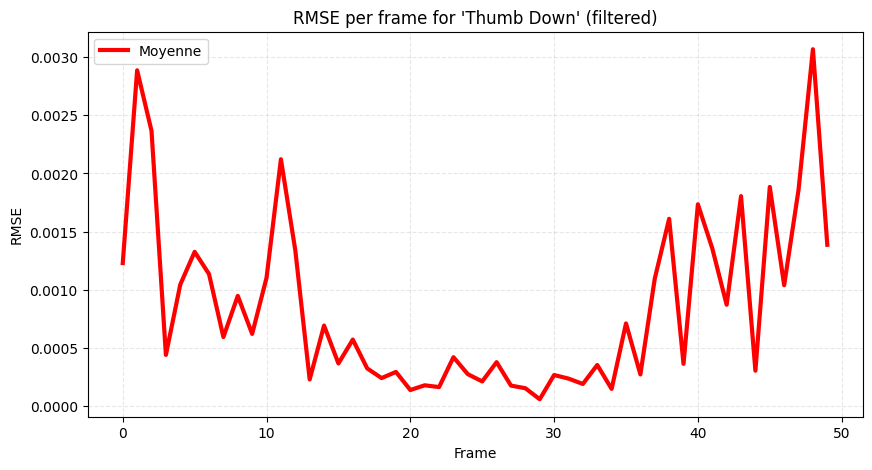

I0000 00:00:1765094073.288020    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094073.289235  251895 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.00113055]), array([[1.22874201e-03, 2.88787853e-03, 2.36678603e-03, 4.38308717e-04,
        1.04374813e-03, 1.32559981e-03, 1.13398896e-03, 5.91857399e-04,
        9.46395644e-04, 6.19166932e-04, 1.10232969e-03, 2.12250636e-03,
        1.33906695e-03, 2.27256253e-04, 6.91281308e-04, 3.64731614e-04,
        5.70464838e-04, 3.22327534e-04, 2.38862470e-04, 2.91949218e-04,
        1.36158249e-04, 1.76842442e-04, 1.61525884e-04, 4.18861870e-04,
        2.72449897e-04, 2.10045148e-04, 3.76137622e-04, 1.74272158e-04,
        1.51623934e-04, 5.70123162e-05, 2.65372002e-04, 2.34670006e-04,
        1.88228367e-04, 3.51829946e-04, 1.45693760e-04, 7.09572958e-04,
        2.70446289e-04, 1.09478718e-03, 1.60981489e-03, 3.61288161e-04,
        1.73450801e-03, 1.35554347e-03, 8.70254864e-04, 1.80494694e-03,
        3.02405052e-04, 1.88417779e-03, 1.03823549e-03, 1.85997642e-03,
        3.06931390e-03, 1.38642506e-03]]), <__main__.DMPVector object at 0x7caa6e111e40>, array([[[ 0.56656879,  0

  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094073.341161  251877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094073.366771  251888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.35it/s]
I0000 00:00:1765094074.192590    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094074.194128  251946 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094074.247716  251930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094074.274964  251939 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/69070.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094084.997310  252546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094085.020431  252552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.43it/s]
I0000 00:00:1765094085.933133    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094085.934398  252614 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094085.984653  252597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094086.007038  252608 inference_feedback_ma


🔎 Turning Hand Counterclockwise : 49 videos loaded
📊 Mean RMSE (filtered)  : 0.4847
📈 RMSE max : 0.9444
🧹 Filtrage : 23/49 vidéos gardées (< 0.4)

📊 Mean RMSE (filtered) : 0.19780665300751457
📈 RMSE max : 0.38261062703092447
📉 RMSE min : 0.10949317772968543


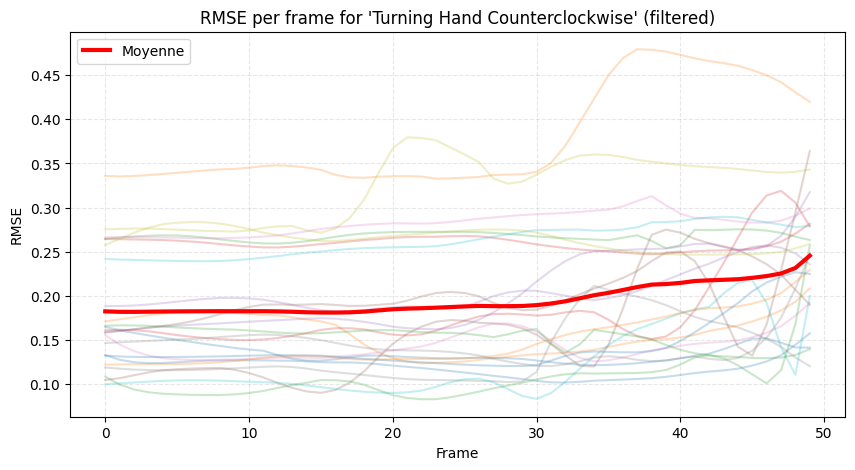

I0000 00:00:1765094118.476576    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.11957027, 0.15896401, 0.2675385 , 0.18741299, 0.20527229,
       0.17008519, 0.14381319, 0.13954909, 0.32521694, 0.12856604,
       0.13619182, 0.15126396, 0.10949318, 0.2592911 , 0.20904509,
       0.20107016, 0.28290991, 0.14479587, 0.26456251, 0.26299037,
       0.1456398 , 0.38261063, 0.15370012]), array([[0.13283958, 0.12762483, 0.12486824, ..., 0.13273143, 0.14463183,
        0.15754388],
       [0.17110563, 0.17347962, 0.17579013, ..., 0.1834314 , 0.19336784,
        0.20871509],
       [0.26474286, 0.26605498, 0.26725374, ..., 0.27136788, 0.26708977,
        0.26329697],
       ...,
       [0.13249455, 0.13138207, 0.1308681 , ..., 0.22175048, 0.22686393,
        0.22482014],
       [0.33586007, 0.33529374, 0.33586566, ..., 0.44207556, 0.43057468,
        0.41987657],
       [0.16620323, 0.16663503, 0.16650857, ..., 0.13012341, 0.13303927,
        0.13966101]]), <__main__.DMPVector object at 0x7caa6dfd3b20>, array([[[ 4.90375786e-01,  4.57411610e-02,  6.14151495e-01, .

I0000 00:00:1765094118.477480  254459 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094118.533629  254446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094118.562643  254450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.78it/s]
I0000 00:00:1765094119.365303    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094119.366018  254510 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094119.413335  254496 inference_feedback_manager.cc:114] Feedba


🔎 Turning Hand Clockwise : 50 videos loaded
📊 Mean RMSE (filtered)  : 0.5277
📈 RMSE max : 0.8679
🧹 Filtrage : 14/50 vidéos gardées (< 0.4)

📊 Mean RMSE (filtered) : 0.20873695686374807
📈 RMSE max : 0.5202767050971676
📉 RMSE min : 0.09111669685417481


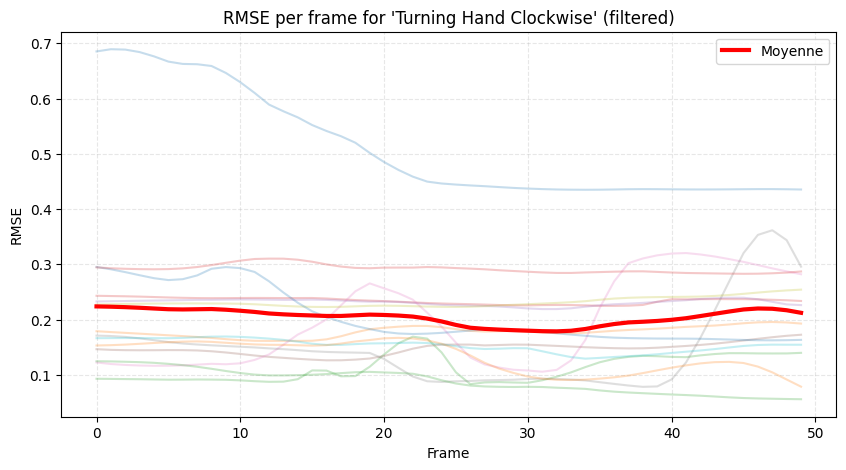

I0000 00:00:1765094163.600588    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.52027671, 0.17873128, 0.11506623, 0.2342214 , 0.23138071,
       0.14771564, 0.2128228 , 0.1658862 , 0.2320525 , 0.15358244,
       0.21150964, 0.13573986, 0.0911167 , 0.2922153 ]), array([[0.68535385, 0.68937113, 0.68870393, 0.68417705, 0.67642046,
        0.66694826, 0.66275448, 0.66221415, 0.65902066, 0.64638593,
        0.6296662 , 0.61020282, 0.58916521, 0.57706825, 0.56599249,
        0.55213687, 0.54135146, 0.53198117, 0.52018491, 0.50176844,
        0.48522432, 0.470937  , 0.45875101, 0.44976674, 0.44637173,
        0.44441892, 0.44285406, 0.44149466, 0.4399038 , 0.43838388,
        0.43719721, 0.43625441, 0.43554054, 0.43516736, 0.43503184,
        0.43515725, 0.4355223 , 0.43598834, 0.43617529, 0.43606388,
        0.43582628, 0.43561897, 0.435553  , 0.43561217, 0.43577368,
        0.43600918, 0.43620287, 0.43622548, 0.4359448 , 0.43548447],
       [0.17904329, 0.17750144, 0.17605213, 0.17461707, 0.17315009,
        0.17168572, 0.17019436, 0.16859581, 0.16690114, 0.1

I0000 00:00:1765094163.601413  257021 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094163.646657  257010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094163.669788  257006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.61it/s]
I0000 00:00:1765094164.452118    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094164.452925  257072 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094164.495881  257067 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/101354.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094200.695144  259053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094200.724639  259061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.19it/s]
I0000 00:00:1765094201.596124    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094201.597080  259118 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094201.646634  259101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094201.679881  259106 inference_feedback_ma


🔎 Rolling Hand Backward : 49 videos loaded
📊 Mean RMSE (filtered)  : 0.4862
📈 RMSE max : 0.8453
🧹 Filtrage : 19/49 vidéos gardées (< 0.4)

📊 Mean RMSE (filtered) : 0.14919773982274243
📈 RMSE max : 0.23297222901551073
📉 RMSE min : 0.09597838672902886


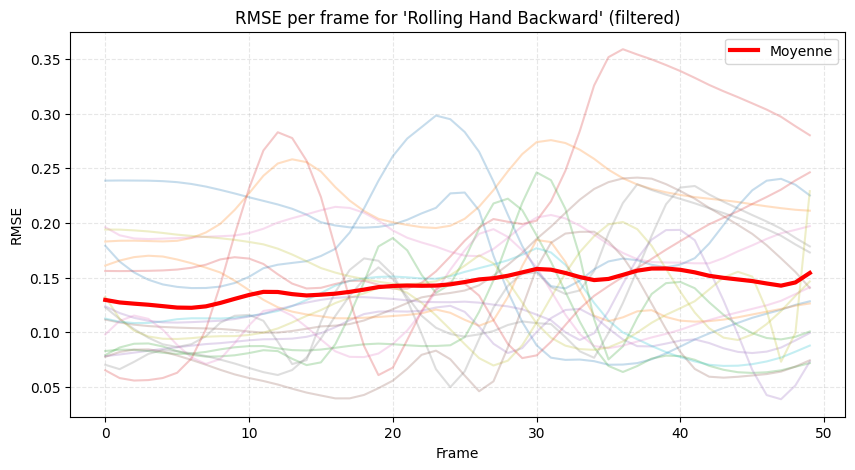

I0000 00:00:1765094210.362453    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.17557577, 0.22371706, 0.11727066, 0.23297223, 0.09832275,
       0.16121702, 0.18795304, 0.15104516, 0.12518653, 0.12436342,
       0.19651452, 0.13298899, 0.11883482, 0.16335534, 0.12433538,
       0.09597839, 0.11819175, 0.1351559 , 0.15177831]), array([[0.23877401, 0.23890697, 0.23884248, 0.23874278, 0.23831206,
        0.23738624, 0.23571487, 0.23333356, 0.23031344, 0.22703444,
        0.22353963, 0.22025703, 0.2169519 , 0.21300705, 0.20765364,
        0.20065854, 0.19769965, 0.19601331, 0.19573038, 0.19642173,
        0.19854424, 0.20292112, 0.20877601, 0.2138502 , 0.22711178,
        0.22787788, 0.21144841, 0.16997076, 0.13715499, 0.10934447,
        0.0879504 , 0.07661646, 0.07462223, 0.07491942, 0.07343465,
        0.07015934, 0.07032942, 0.07165241, 0.07515927, 0.08056614,
        0.08684333, 0.09330568, 0.09881873, 0.1038376 , 0.10851363,
        0.11316317, 0.11692996, 0.12050798, 0.12499542, 0.12827623],
       [0.18302123, 0.18372391, 0.18379353, 0.18344786, 0.18

I0000 00:00:1765094210.363395  259584 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094210.404975  259570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094210.428832  259575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.45it/s]
I0000 00:00:1765094211.304299    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094211.305610  259635 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094211.357963  259617 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/54315.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094235.185068  260950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094235.220222  260959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.77it/s]
I0000 00:00:1765094236.092847    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094236.093925  261016 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094236.141110  261000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094236.167770  261009 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/139080.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765094252.940931  261935 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094252.991401  261919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094253.018199  261924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.23it/s]
I0000 00:00:1765094253.877312    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094253.878861  261986 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094253.931032  261968 inference_feedback_manager.cc:114] Feedba


🔎 Rolling Hand Forward : 48 videos loaded
📊 Mean RMSE (filtered)  : 0.5503
📈 RMSE max : 1.0412
🧹 Filtrage : 12/48 vidéos gardées (< 0.4)

📊 Mean RMSE (filtered) : 0.14567682487457154
📈 RMSE max : 0.3125235825094507
📉 RMSE min : 0.07281529478836613


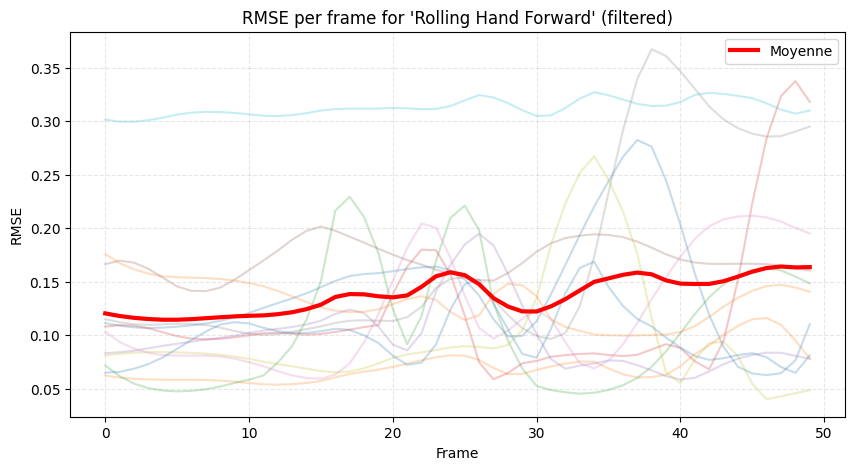

I0000 00:00:1765094257.010479    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.1511559 , 0.07281529, 0.12118361, 0.13756198, 0.10390752,
       0.17147725, 0.13273616, 0.19631669, 0.11234907, 0.31252358,
       0.10284369, 0.13325114]), array([[0.11108393, 0.10883411, 0.10718701, 0.10660572, 0.1069141 ,
        0.10780992, 0.10907563, 0.11078873, 0.11322041, 0.11657528,
        0.12065207, 0.1253374 , 0.12989057, 0.13423185, 0.13904748,
        0.14473792, 0.15058645, 0.15513766, 0.15698975, 0.15783847,
        0.15965402, 0.1617083 , 0.163295  , 0.16393985, 0.16064209,
        0.15195416, 0.13686805, 0.11481856, 0.09865225, 0.09915614,
        0.11303613, 0.1381631 , 0.1655045 , 0.19345382, 0.21997466,
        0.24371724, 0.26644405, 0.28226114, 0.27599552, 0.24466252,
        0.2032813 , 0.15755271, 0.11895584, 0.08895992, 0.07045278,
        0.06407999, 0.06255791, 0.06433033, 0.07630414, 0.11005979],
       [0.06204612, 0.06028593, 0.05907073, 0.05850676, 0.05825055,
        0.05817756, 0.05822342, 0.05807713, 0.05743967, 0.05639773,
        0.05513

I0000 00:00:1765094257.011452  262139 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094257.058009  262123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094257.084534  262133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.20it/s]
I0000 00:00:1765094258.005626    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094258.006980  262190 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094258.051331  262177 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/132925.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765094265.253960    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094265.255347  262598 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094265.317820  262585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094265.347659  262592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.31it/s]
I0000 00:00:1765094266.180412    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094266.181373  262649 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/144872.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094270.063125  262839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094270.099844  262841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.61it/s]
I0000 00:00:1765094270.929625    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094270.930432  262907 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094270.973495  262889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094270.999290  262902 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/72326.mp4 : AttributeError("'list' object has no attribute 'shape'")

🔎 Pushing Hand Away : 47 videos loaded
📊 Mean RMSE (filtered)  : 0.5572
📈 RMSE max : 1.0520
🧹 Filtrage : 17/47 vidéos gardées (< 0.4)

📊 Mean RMSE (filtered) : 0.14073356670676482
📈 RMSE max : 0.30775250736016213
📉 RMSE min : 0.0980376340344451


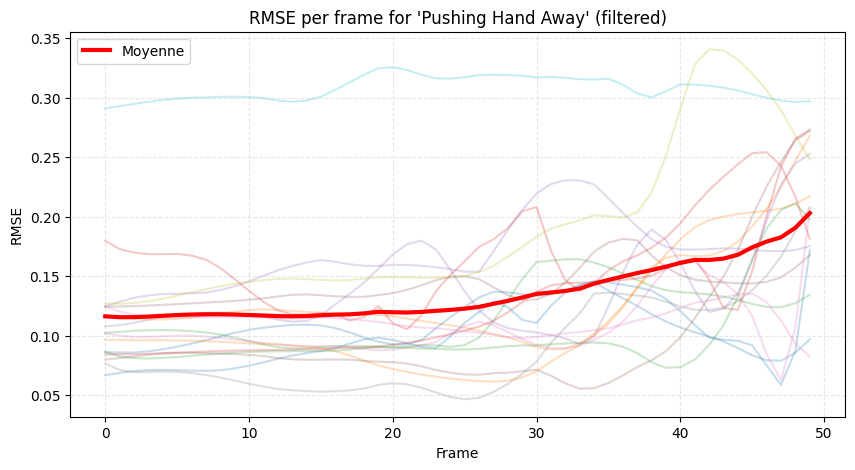

I0000 00:00:1765094303.385436    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.09912005, 0.13717759, 0.11927666, 0.17081716, 0.17026181,
       0.14282819, 0.10950138, 0.09803763, 0.20004997, 0.30775251,
       0.11276966, 0.12288466, 0.10427931, 0.13044708, 0.14310966,
       0.11127912, 0.11287822]), array([[0.06662886, 0.0686593 , 0.0702497 , 0.07097929, 0.07112764,
        0.07088168, 0.07048451, 0.07027118, 0.07081541, 0.07240821,
        0.07465134, 0.07747142, 0.08054378, 0.08316856, 0.08523612,
        0.08716694, 0.08949574, 0.09323604, 0.09675772, 0.09819372,
        0.09628437, 0.093447  , 0.09055321, 0.08950373, 0.09916054,
        0.11070009, 0.11974815, 0.12868918, 0.12380797, 0.11318051,
        0.11049617, 0.12501332, 0.13626528, 0.14257205, 0.14481091,
        0.13787188, 0.13139996, 0.12490122, 0.1179044 , 0.111717  ,
        0.10676517, 0.10272026, 0.09927382, 0.09506478, 0.08951925,
        0.08340802, 0.07923305, 0.07893793, 0.08554692, 0.09682936],
       [0.11641049, 0.11514742, 0.11444504, 0.11373548, 0.11346049,
        0.113992

I0000 00:00:1765094303.386385  264700 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094303.428731  264685 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094303.441307  264693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.34it/s]
I0000 00:00:1765094304.274762    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094304.275820  264751 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094304.333663  264735 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/15829.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094318.003942  265500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094318.035354  265508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.08it/s]
I0000 00:00:1765094318.915092    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094318.915979  265567 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094318.967146  265549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094318.996006  265561 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/17.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765094329.853242  266182 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094329.907188  266167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094329.937284  266177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.84it/s]
I0000 00:00:1765094330.760343    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094330.761448  266235 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094330.807751  266220 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/52056.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765094331.746181  266286 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094331.791292  266271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765094331.826750  266281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.62it/s]
I0000 00:00:1765094332.709476    4734 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765094332.710451  266337 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765094332.763866  266320 inference_feedback_manager.cc:114] Feedba


🔎 Shaking Hand : 47 videos loaded
📊 Mean RMSE (filtered)  : 0.4014
📈 RMSE max : 1.1739
🧹 Filtrage : 35/47 vidéos gardées (< 0.4)

📊 Mean RMSE (filtered) : 0.20842368838031242
📈 RMSE max : 0.4852942304670966
📉 RMSE min : 0.09760388404442986


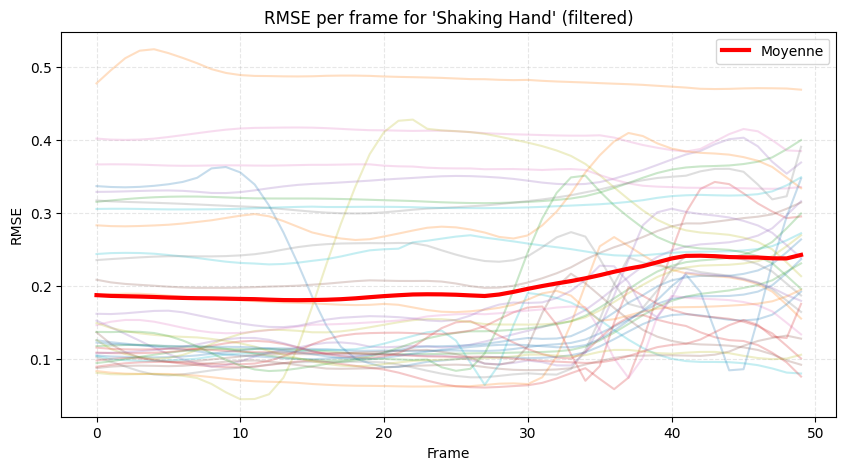

(array([0.13747094, 0.13807562, 0.33194307, 0.16028076, 0.17264755,
       0.23101909, 0.40602891, 0.13599412, 0.28766266, 0.11868703,
       0.15008983, 0.48529423, 0.13624251, 0.1222566 , 0.34944615,
       0.09760388, 0.35577571, 0.32179573, 0.16733742, 0.24805   ,
       0.21189928, 0.31597404, 0.1642133 , 0.13205365, 0.17367261,
       0.12331096, 0.15402271, 0.23955041, 0.11075322, 0.3123881 ,
       0.14257561, 0.17660465, 0.1946073 , 0.11420029, 0.17530118]), array([[0.10500463, 0.10366569, 0.10309733, ..., 0.20113714, 0.2176833 ,
        0.23661107],
       [0.08371225, 0.08148936, 0.08021195, ..., 0.19234422, 0.17443168,
        0.15550783],
       [0.3151787 , 0.31710271, 0.31891748, ..., 0.37606907, 0.38715161,
        0.39967106],
       ...,
       [0.13725502, 0.13702354, 0.13755124, ..., 0.2310803 , 0.21399999,
        0.19605291],
       [0.11578014, 0.11414781, 0.11344718, ..., 0.13088111, 0.12890572,
        0.17560966],
       [0.16205522, 0.16168245, 0.16270941, ..

In [61]:
def analyse_full_jester(): 
    for i in labels_jester:
        print(analyse_label_filtered(i, n = 100, target_len=50, n_basis=30)) 
    
analyse_full_jester()